In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import datetime
import xlrd
import re

In [26]:
# Determine the current path of the notebook
notebook_path = os.path.abspath("big_project.ipynb")
notebook_dir = os.path.dirname(notebook_path).replace('\\', '/')
print("Current notebook directory:", notebook_dir)
HOME_DIR = f'{notebook_dir}'
DATA_DIR = f'{HOME_DIR}/data/'
print("Data directory set to:", DATA_DIR)
RAW_DATA_DIR = f'{DATA_DIR}/raw_data/'

Current notebook directory: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project
Data directory set to: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data/


### Load and Populate Solar Panel Data ###

The solar panel data is the yearly , monthly and daily inverter data from home solar system.  This data is retrieved from solas web site . The web site is a user logon website. The data had to be extracted manually , a period at a time. 

The data is placed in the directory ./big_project/data/raw_data/solar. 

[Home Solar System Website](https://www.soliscloud.com/station/stationDetails/generalSituation/1298491919449681542?glyun_vue2=%2F%23%2Fstation) 


[pandas read excel](https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html) 


[xlrd](https://pypi.org/project/xlrd/) 



In [27]:
print(f"Listing all files in the raw data directory: {RAW_DATA_DIR}")
all_dfs = []
for file in glob.glob(f'{RAW_DATA_DIR}/solar/Daily*xls'):
    print(file)
    df_header = pd.read_excel(file, nrows=5, header=None)
    # get date from header
    the_date = None
    the_date_label = df_header.iat[0,0]
    # format of date is Plant_12-09-2024Chart
    result = re.search(r'(\d{2}-\d{2}-\d{4})', str(the_date_label))
    if result:
        date_str = result.group(1)
        the_date = datetime.datetime.strptime(date_str, '%d-%m-%Y').date()
    else:
        print("DQ Issue: Date not found in header")
        break
    # Get Total Yield from header oday Yield(kWh):29.500kWh
    total_yield_label = df_header.iat[3,0]
    result_yield = re.search(r'oday Yield\(kWh\):([\d\.]+)kWh', str(total_yield_label))
    if result_yield:
        total_yield = float(result_yield.group(1))
        print("Total Yield (kWh):", total_yield)
    print("Date from header:", the_date)
    #print(df_header)
    # The file needs to be read from line 29
    df = pd.read_excel(file,skiprows=28)
    # add insert date as first column
    df.insert(0, 'Date', the_date)
    # The total yield as last column
    df['Total_Yield(kWh)'] = total_yield
    # add file name column in case there are duplicates
    df['Source_File'] = os.path.basename(file)
    #print(df.head())
    all_dfs.append(df)
# Combine all at once
df_raw_solar = pd.concat(all_dfs, ignore_index=True)
# remove all_dfs to free memory
del all_dfs
    


Listing all files in the raw data directory: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data//raw_data/
c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data//raw_data//solar\Daily+Power+Station+Chart_19-11-2025 (1).xls
Total Yield (kWh): 29.5
Date from header: 2024-09-12
c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data//raw_data//solar\Daily+Power+Station+Chart_19-11-2025 (10).xls
Total Yield (kWh): 9.6
Date from header: 2024-09-21
c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data//raw_data//solar\Daily+Power+Station+Chart_19-11-2025 (100).xls
Total Yield (kWh): 8.6
Date from header: 2024-12-19
c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data//raw_data//solar\Daily+Power+Station+Chart_19-11-2025 (11)

__Validate Solar dataframe__

Check for the following
1. Shape
2. Columns
3. Any dates missing
4. Row count per day

In [28]:
print("Combined DataFrame shape:", df_raw_solar.shape)
print("DataFrame info:")
df_raw_solar.info()
print("Columns:", df_raw_solar.columns.tolist())
df_dates = df_raw_solar['Date'].unique()
print(f"Dates Min: {min(df_dates)}")
print(f"Dates Max: {max(df_dates)}")
print("Total unique dates in data:", len(df_dates))
print("Date Range In Days:", (max(df_dates) - min(df_dates)).days)
# Delete all rows after 2025-10-31
df_raw_solar = df_raw_solar[df_raw_solar['Date'] <= datetime.date(2025, 10, 31)]
# Adjusted shape after filtering dates
print("DataFrame shape after filtering dates:", df_raw_solar.shape)
# find missing dates
# create a complete date range
all_dates = pd.date_range(start=min(df_dates), end=max(df_dates))
# get the difference between all_dates and df_dates
missing_dates = all_dates.difference(df_dates)
print("Missing dates:", missing_dates)


Combined DataFrame shape: (118142, 11)
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118142 entries, 0 to 118141
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Date              118142 non-null  object 
 1   Number            118142 non-null  int64  
 2   Time              118142 non-null  object 
 3   Working State     118142 non-null  object 
 4   PV(W)             118142 non-null  float64
 5   Battery(W)        118142 non-null  float64
 6   Grid(W)           118142 non-null  float64
 7   Load(W)           118142 non-null  float64
 8   SOC(%)            118142 non-null  float64
 9   Total_Yield(kWh)  118142 non-null  float64
 10  Source_File       118142 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 9.9+ MB
Columns: ['Date', 'Number', 'Time', 'Working State', 'PV(W)', 'Battery(W)', 'Grid(W)', 'Load(W)', 'SOC(%)', 'Total_Yield(kWh)', 'Source_File']
Dates

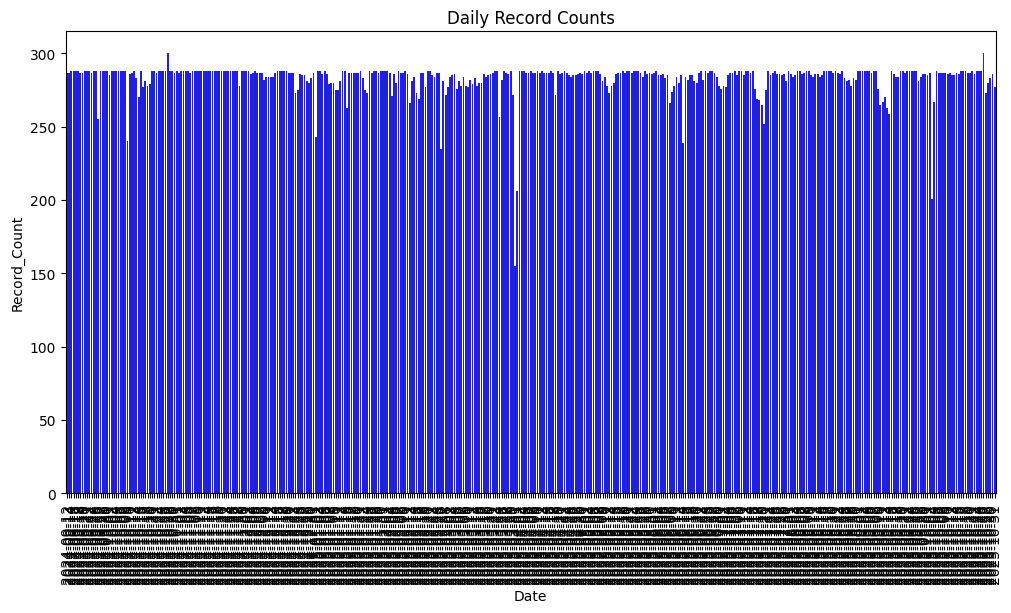

Outliers with MORE than 300 records:


,Date,Source_File


In [29]:
# Do a aggregation to daily level
df_date_counts = df_raw_solar['Date'].value_counts().reset_index()
df_date_counts.columns = ['Date', 'Record_Count']
df_date_counts = df_date_counts.sort_values(by='Date')
# Plot the daily record counts
plt.figure(figsize=(12,6))
sns.barplot(data=df_date_counts, x='Date', y='Record_Count', color='blue')
plt.xticks(rotation=90)
plt.title('Daily Record Counts')
plt.show()
# print outliers where record count is less than 24
outliers = df_date_counts[df_date_counts['Record_Count'] > 300]
print("Outliers with MORE than 300 records:")
df_dups = df_raw_solar[df_raw_solar['Date'].isin(outliers['Date'])][['Date','Source_File']].drop_duplicates().sort_values(by='Date')
df_dups

__Load Raw Monthly__

In [30]:

all_dfs = []
for file in glob.glob(f'{RAW_DATA_DIR}/solar/Monthly*xls'):
    df = pd.read_excel(file,skiprows=28)
    # add insert date as first column
    df.insert(0, 'Date', the_date)
    # The total yield as last column
    df['Total_Yield(kWh)'] = total_yield
    # add file name column in case there are duplicates
    df['Source_File'] = os.path.basename(file)
    #print(df.head())
    all_dfs.append(df)
# Combine all at once
df_raw_monthly_solar = pd.concat(all_dfs, ignore_index=True)
# remove all_dfs to free memory
del all_dfs
# Rename column Time to Date
df_raw_monthly_solar = df_raw_monthly_solar.rename(columns={'Time':'Date'})
    

__Validate Raw Monthly__

TODO

In [31]:
# TODO: Validate Raw Monthly
# --- IGNORE ---

__Load Yearly__

In [32]:

all_dfs = []
for file in glob.glob(f'{RAW_DATA_DIR}/solar/Annual*xls'):
    df = pd.read_excel(file,skiprows=28)
    # add insert date as first column
    df.insert(0, 'Date', the_date)
    # The total yield as last column
    df['Total_Yield(kWh)'] = total_yield
    # add file name column in case there are duplicates
    df['Source_File'] = os.path.basename(file)
    #print(df.head())
    all_dfs.append(df)
# Combine all at once
df_raw_annual_solar = pd.concat(all_dfs, ignore_index=True)
# remove all_dfs to free memory
del all_dfs
# Rename column Time to Date
df_raw_annual_solar = df_raw_annual_solar.rename(columns={'Time':'Month'})
# Create Date column from Month
df_raw_annual_solar['Date'] = '01-' + df_raw_annual_solar['Month']
# Convert Date column to datetime
df_raw_annual_solar['Date'] = pd.to_datetime(df_raw_annual_solar['Date'], format='%d-%m-%Y')
    

__Load ESB Microgeneration Data__

In [33]:
# load into pandas dataframe csv file
df_raw_esb_microgen = pd.read_csv(f'{RAW_DATA_DIR}/esb/BGE_Export_HDF_18_11_2025.csv')

__ Dublin Aireport Weather __

The Dublin Airport weather is the closest weather station. 

[Dublin Airport Weither](https://cli.fusio.net/cli/climate_data/webdata/hly532.csv)


Header 

date:  -  Date and Time (utc)
rain:  -  Precipitation Amount (mm)	  
temp:  -  Air Temperature (C)	
wetb:  -  Wet Bulb Temperature (C)
dewpt: -  Dew Point Temperature (C)             
rhum:  -  Relative Humidity (%)
vappr: -  Vapour Pressure (hPa)	 
msl:   -  Mean Sea Level Pressure (hPa)
wdsp:  -  Mean Wind Speed (knot)
wddir: -  Predominant Wind Direction (degree)
ww:    -  Synop code for Present Weather
w:     -  Synop code for Past Weather
sun:   -  Sunshine duration (hours)
vis:   -  Visibility (m)
clht:  -  Cloud height (100's of ft) - 999 if none 
clamt: -  Cloud amount
ind:   -  Indicator

In [34]:
df_weather_dublin = pd.read_csv(f'{RAW_DATA_DIR}/weather/hly532.csv', skiprows=23)
df_weather_dublin['new_date_time'] = pd.to_datetime(df_weather_dublin['date'], format='%d-%b-%Y %H:%M')
df_weather_dublin['new_date'] = df_weather_dublin['new_date_time'].dt.date
# Only interested in dates between 2024-09-10 and 2025-10-31
df_weather_dublin = df_weather_dublin[(df_weather_dublin['new_date'] >= pd.to_datetime('2024-09-10').date()) & (df_weather_dublin['new_date'] <= pd.to_datetime('2025-10-31').date())]  


# show first 5 rows
df_dates=df_weather_dublin['new_date'].value_counts()
df_weather_dublin

C:\Users\cw171001\AppData\Local\Temp\ipykernel_29916\4127421478.py:1: DtypeWarning: Columns (8,9,14,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_weather_dublin = pd.read_csv(f'{RAW_DATA_DIR}/weather/hly532.csv', skiprows=23)


,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,...,ind.4,wddir,ww,w,sun,vis,clht,clamt,new_date_time,new_date
698568,10-sep-2024 00:00,0,0.0,0,14.1,0,12.6,11.3,13.4,83,...,2,250,2,52,0.0,20000,15,7,2024-09-10 00:00:00,2024-09-10
698569,10-sep-2024 01:00,0,0.0,0,14.1,0,12.4,10.9,13.0,81,...,2,250,2,11,0.0,20000,14,7,2024-09-10 01:00:00,2024-09-10
698570,10-sep-2024 02:00,2,0.0,0,14.0,0,12.6,11.3,13.5,84,...,2,250,50,22,0.0,20000,13,7,2024-09-10 02:00:00,2024-09-10
698571,10-sep-2024 03:00,0,0.0,0,13.8,0,12.7,11.8,13.8,87,...,2,250,2,52,0.0,20000,10,7,2024-09-10 03:00:00,2024-09-10
698572,10-sep-2024 04:00,0,0.0,0,13.7,0,12.4,11.2,13.4,85,...,2,250,2,11,0.0,20000,15,7,2024-09-10 04:00:00,2024-09-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708571,31-oct-2025 19:00,0,0.0,0,11.2,0,9.4,7.5,10.3,78,...,2,160,2,11,0.0,35000,130,6,2025-10-31 19:00:00,2025-10-31
708572,31-oct-2025 20:00,0,0.0,0,11.2,0,9.6,8.0,10.7,80,...,2,150,2,11,0.0,35000,90,6,2025-10-31 20:00:00,2025-10-31
708573,31-oct-2025 21:00,0,0.5,0,11.2,0,10.3,9.4,11.8,89,...,2,150,60,62,0.0,8000,27,7,2025-10-31 21:00:00,2025-10-31
708574,31-oct-2025 22:00,0,1.1,0,10.8,0,9.6,8.4,11.0,85,...,2,160,21,62,0.0,20000,48,8,2025-10-31 22:00:00,2025-10-31


https://cli.fusio.net/cli/climate_data/webdata/hly532.csv

To find "solar brightness" for weather in Ireland using Python, we technically need to look for Solar Irradiance.In weather data, this is measured in Watts per square meter ($W/m^2$). The most common metric is GHI (Global Horizontal Irradiance), which represents the total power of the sun hitting a horizontal surface (like a flat solar panel or the ground).1Here are the two best ways to get this data for free in Python:Open-Meteo (Best for Forecasts): Free, requires no API key, and is very easy to use for current/future weather.PVGIS via pvlib (Best for Solar Planning): Uses European Commission data, excellent for calculating potential solar energy generation based on historical averages.Option 1: Get Live & Forecast Solar Data (Open-Meteo)This is the simplest method. It uses the Open-Meteo API to get the GHI for any location in Ireland (defined by latitude and longitude).Prerequisites:You will need the requests and pandas libraries.

In [35]:
import requests
import pandas as pd

def get_solar_brightness(lat, lon):
    # Open-Meteo API endpoint for solar forecast
    url = "https://api.open-meteo.com/v1/forecast"
    
    # Parameters: shortwave_radiation is effectively GHI (Global Horizontal Irradiance)
    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": ["shortwave_radiation", "direct_radiation", "diffuse_radiation", "cloud_cover"],
        "timezone": "Europe/Dublin"
    }
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        
        # Process hourly data
        hourly = data['hourly']
        df = pd.DataFrame({
            'Time': pd.to_datetime(hourly['time']),
            'GHI (W/m²)': hourly['shortwave_radiation'],
            'Cloud Cover (%)': hourly['cloud_cover']
        })
        
        return df
    
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

# Example: Coordinates for Dublin, Ireland
latitude = 53.3498
longitude = -6.2603

df = get_solar_brightness(latitude, longitude)

if df is not None:
    # Filter for daylight hours only (GHI > 0) to see "brightness"
    daylight_data = df[df['GHI (W/m²)'] > 0].head(12)
    
    print(f"--- Solar Brightness Forecast for Dublin ---")
    print(daylight_data.to_string(index=False))
    
    # Simple Interpretation
    current_ghi = daylight_data.iloc[0]['GHI (W/m²)']
    print("\n--- Interpretation ---")
    if current_ghi > 800:
        print("Status: Very Sunny/Bright ☀️")
    elif current_ghi > 300:
        print("Status: Moderate/Partly Cloudy ⛅")
    else:
        print("Status: Low Light/Cloudy ☁️")

--- Solar Brightness Forecast for Dublin ---
               Time  GHI (W/m²)  Cloud Cover (%)
2025-11-19 09:00:00        33.0                0
2025-11-19 10:00:00       122.0               41
2025-11-19 11:00:00       193.0                0
2025-11-19 12:00:00       276.0                0
2025-11-19 13:00:00       281.0                0
2025-11-19 14:00:00       237.0               99
2025-11-19 15:00:00        99.0              100
2025-11-19 16:00:00        29.0               47
2025-11-19 17:00:00         2.0              100
2025-11-20 09:00:00        31.0                0
2025-11-20 10:00:00       134.0                0
2025-11-20 11:00:00       217.0                2

--- Interpretation ---
Status: Low Light/Cloudy ☁️


Option 2: Get Historical/Planning Data (PVGIS)
If you are planning a solar panel installation and need to know the average brightness for a specific month in Ireland, the PVGIS database (provided by the EU Science Hub) is the gold standard. We access this using the pvlib library.

Prerequisites:

[Photovoltaic Geographical Information System](https://joint-research-centre.ec.europa.eu/photovoltaic-geographical-information-system-pvgis_en)
[pvlib](https://pvlib-python.readthedocs.io/en/stable/)

In [37]:
import pvlib
import pandas as pd

def get_average_solar_data(lat, lon):
    print("Fetching data from PVGIS (European Commission)...")
    
    try:
        # fetch_pvgis_tmy returns a tuple, we need the first element (the dataframe)
        data, metadata = pvlib.iotools.get_pvgis_tmy(
            latitude=lat, 
            longitude=lon,
            map_variables=True,
            startyear=2022,
            endyear=2023
        )
        
        # Resample to daily averages to see seasonal brightness
        daily_avg = data['ghi'].resample('D').mean()
        
        # Map day numbers
        #daily_avg.index = daily_avg.index.strftime('%B')
        print(daily_avg.head())
        
        return daily_avg

    except Exception as e:
        print(f"Error: {e}")
        return None

# Example: Coordinates for Cork, Ireland
# Example: Coordinates for Bettystown, Ireland
latitude = 53.7014
longitude = -6.2461
monthly_data = get_average_solar_data(latitude, longitude)

if monthly_data is not None:
    print("\n--- Average Solar Irradiance (GHI) in Bettystown (W/m²) ---")
    print(monthly_data)
monthly_data = get_average_solar_data(latitude, longitude)
monthly_data

Fetching data from PVGIS (European Commission)...
Error: startyear, endyear: Incorrect time period. The calculation period for this app should be at least 10 years.
Fetching data from PVGIS (European Commission)...
Error: startyear, endyear: Incorrect time period. The calculation period for this app should be at least 10 years.


--- Theoretical Clear Sky Limit for Bettystown ---
Date: 2024-11-20
Max Potential Energy: 1474.20 kWh/m²
Peak Brightness (Noon): 832 W/m²


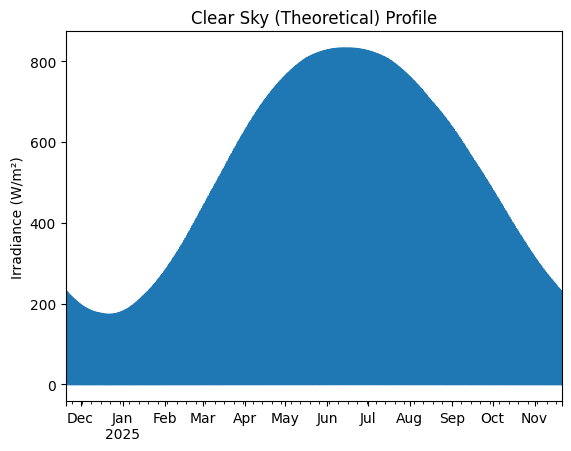

In [39]:
import pandas as pd
import pvlib
from pvlib.location import Location

# 1. Define Location (Bettystown, Ireland)
lat, lon = 53.7014, -6.2461
tz = 'Europe/Dublin'
site = Location(lat, lon, tz=tz, altitude=10, name='Bettystown')

# 2. Define the time period (e.g., Tomorrow)
# We create a frequency of 10 minutes to get a smooth curve
times = pd.date_range(start='2024-11-20 00:00', end='2025-11-20 23:59', freq='10min', tz=tz)

# 3. Calculate Clear Sky Data
# This uses the 'Ineichen' model which is standard for clear sky
# It automatically estimates atmospheric clarity (turbidity) based on your location
cs = site.get_clearsky(times, model='ineichen')

# 4. Calculate Total Daily Energy (Insolation)
# GHI is Global Horizontal Irradiance (Watts/m2)
# We sum the watts and divide by 6 (since data is every 10 mins) and 1000 (to get kWh)
total_daily_energy = cs['ghi'].sum() / 6 / 1000

print(f"--- Theoretical Clear Sky Limit for Bettystown ---")
print(f"Date: {times[0].date()}")
print(f"Max Potential Energy: {total_daily_energy:.2f} kWh/m²")
print(f"Peak Brightness (Noon): {cs['ghi'].max():.0f} W/m²")

# Optional: Plot it to see the perfect curve
try:
    import matplotlib.pyplot as plt
    cs['ghi'].plot()
    plt.ylabel('Irradiance (W/m²)')
    plt.title('Clear Sky (Theoretical) Profile')
    plt.show()
except ImportError:
    print("Install matplotlib to see the graph.")